In [6]:
from re import S
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Carga de datos

In [8]:
df = pd.read_csv('close_normalized_prices_index.csv')
# df['X'] = df['X'].apply(lambda x: np.fromstring(x.strip("[]"), sep=' '))
df['Y'] = df['Y'].apply(lambda x: np.fromstring(x.strip("[]"), sep=' '))

In [9]:
df['X'] = df['X'].apply(lambda x:np.fromstring(x.replace('[', '').replace(']', '').replace('\n', ' '), sep=' ').reshape(14, 28))

# Division train-test

In [10]:
X_train, X_test, y_train, y_test = train_test_split(np.stack(df.X.to_numpy()).astype(np.float32),
                                                    np.stack(df.Y.to_numpy()).astype(np.float32),
                                                    test_size=0.25,
                                                    random_state=42)

# Conversión a tensores

In [11]:
X_train = torch.tensor(X_train, dtype=torch.float32).reshape(-1, 14, 28)
y_train = torch.tensor(y_train, dtype=torch.float32)

X_test = torch.tensor(X_test, dtype=torch.float32).reshape(-1, 14, 28)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Dataloaders

In [12]:
# Crear DataLoaders
batch_size = 100
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

In [13]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Modelo

In [14]:
class CNN_LSTM(nn.Module):

  def __init__(self):
    super(CNN_LSTM, self).__init__()
    # Capa Conv1D para extracción de características espaciales
    self.conv1 = nn.Conv1d(in_channels=14, out_channels=64, kernel_size=5, padding=1)
    self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, padding=1)
    self.conv3 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=5, padding=1)
    self.conv4 = nn.Conv1d(in_channels=256, out_channels=512, kernel_size=2, padding=1)

    # Batch normalization
    self.bn1 = nn.BatchNorm1d(64)
    self.bn2 = nn.BatchNorm1d(128)
    self.bn3 = nn.BatchNorm1d(256)
    self.bn4 = nn.BatchNorm1d(512)

    # Max Pool
    self.pool = nn.MaxPool1d(kernel_size=2)

    # Dropout
    self.dropout_layer = nn.Dropout(p=0.15)

    # ReLu
    self.relu = nn.ReLU()

    # Capa LSTM
    self.lstm = nn.LSTM(input_size=512, hidden_size=128, num_layers=5, batch_first=True)

    # Capa Fully Connected
    self.fc1 = nn.Linear(128, 64)  # Predecir 5 valores
    self.fc2 = nn.Linear(64, 32)  # Predecir un solo valor
    self.fc3 = nn.Linear(32, 16)  # Predecir un solo valor
    self.fc4 = nn.Linear(16, 5)  # Predecir un solo valor

    # Inicialización de pesos
    self._initialize_weights()

  def _initialize_weights(self):
    for m in self.modules():
      if isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
          nn.init.zeros_(m.bias)

  def forward(self, x):
    # Primer capa completa
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.pool(x)

    # Segunda capa completa
    x = self.conv2(x)
    x = self.bn2(x)
    x = self.relu(x)
    x = self.pool(x)

    # Tercera capa completa
    x = self.conv3(x)
    x = self.bn3(x)
    x = self.relu(x)
    x = self.pool(x)

    # Cuarta capa completa
    x = self.conv4(x)
    x = self.bn4(x)
    x = self.relu(x)
    x = self.pool(x)

    # Reordenar datos
    # Antes batch, channels, seq_length
    x = x.permute(0, 2, 1)
    # Después batch, seq_length, features

    # Capas LSTM
    x, _ = self.lstm(x)

    # Se toma la ultima salida de secuencia, que es la representación de la serie
    x = x[:, -1, :]

    # Capas Fully Connected
    x = self.dropout_layer(x)
    x = self.fc1(x)
    x = self.relu(x)
    x = self.dropout_layer(x)
    x = self.fc2(x)
    x = self.relu(x)
    x = self.dropout_layer(x)
    x = self.fc3(x)
    x = self.relu(x)
    x = self.dropout_layer(x)
    x = self.fc4(x)

    return x

# Función de perdida propia

In [15]:
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()

    def forward(self, y_pred, y_true):
        mse = torch.mean(((y_pred - y_true)*100) ** 2)
        return mse

# Train model

Epoch 1/200, Loss: 1106.769240, 33.268142
Epoch 2/200, Loss: 1052.142455, 32.436745
Epoch 3/200, Loss: 1034.678006, 32.166411
Epoch 4/200, Loss: 1018.863158, 31.919636
Epoch 5/200, Loss: 1006.570725, 31.726499
Epoch 6/200, Loss: 992.913521, 31.510530
Epoch 7/200, Loss: 977.958062, 31.272321
Epoch 8/200, Loss: 962.761357, 31.028396
Epoch 9/200, Loss: 950.396693, 30.828505
Epoch 10/200, Loss: 937.124598, 30.612491
Epoch 11/200, Loss: 925.127776, 30.415913
Epoch 12/200, Loss: 913.990140, 30.232270
Epoch 13/200, Loss: 902.747799, 30.045762
Epoch 14/200, Loss: 893.234787, 29.887034
Epoch 15/200, Loss: 880.634896, 29.675493
Epoch 16/200, Loss: 868.470426, 29.469822
Epoch 17/200, Loss: 861.796775, 29.356375
Epoch 18/200, Loss: 849.171631, 29.140550
Epoch 19/200, Loss: 840.290465, 28.987764
Epoch 20/200, Loss: 830.749961, 28.822733
Epoch 21/200, Loss: 826.129381, 28.742467
Epoch 22/200, Loss: 814.356605, 28.536934
Epoch 23/200, Loss: 806.165905, 28.393061
Epoch 24/200, Loss: 796.930588, 28.229

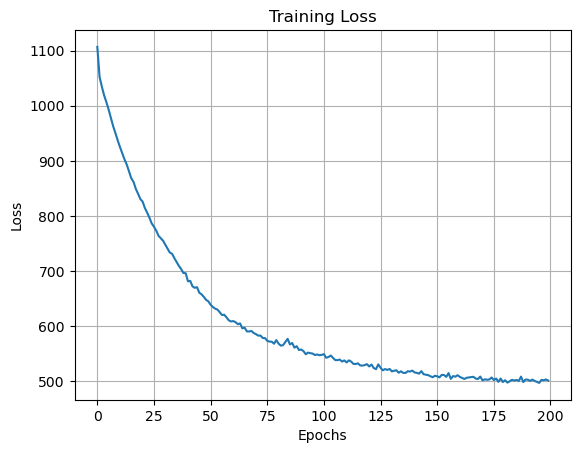

In [17]:
import math
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_LSTM().to(device)
criterion = CustomLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0015, weight_decay=1e-5)
epochs = 200
losses = list()
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        train_loss = total_loss / len(train_loader)
    losses.append(train_loss)

    print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss:.6f}, {math.sqrt(train_loss):.6f}")

import matplotlib.pyplot as plt
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid()
plt.show()

In [ ]:
model.eval()
predictions = []
actuals = []

# Score en test
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred = model(X_batch)

        predictions.append(y_pred.cpu().numpy())
        actuals.append(y_batch.cpu().numpy())

# Convertir listas en arrays
predictions_test = np.concatenate(predictions).reshape(-1, 5)
actuals_test = np.concatenate(actuals).reshape(-1, 5)

# Score en train
with torch.no_grad():
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred = model(X_batch)

        predictions.append(y_pred.cpu().numpy())
        actuals.append(y_batch.cpu().numpy())

# Convertir listas en arrays
predictions_train = np.concatenate(predictions).reshape(-1, 5)
actuals_train = np.concatenate(actuals).reshape(-1, 5)

In [ ]:
print("Evaluación del modelo:")
print("MAE Train:", np.mean(np.abs(predictions_train - actuals_train)),
      "MAE Test:", np.mean(np.abs(predictions_test - actuals_test)))
print("MSE Train:", np.mean((predictions_train - actuals_train) ** 2),
      "MSE Test:", np.mean((predictions_test - actuals_test) ** 2))
print("RMSE Train:", np.sqrt(np.mean((predictions_train - actuals_train) ** 2)),
      "RMSE Test:", np.sqrt(np.mean((predictions_test - actuals_test) ** 2)))

Evaluación del modelo:
MAE Train: 0.16892084 MAE Test: 0.20223841
MSE Train: 0.05833414 MSE Test: 0.09049564
RMSE Train: 0.2415246 RMSE Test: 0.30082494


**V1 eval (20 epochs)**

Evaluación del modelo:

MAE Train: 0.18331179 MAE Test: 0.20078355

MSE Train: 0.07033019 MSE Test: 0.08963985

RMSE Train: 0.26519838 RMSE Test: 0.29939914

**V1 eval (50 epochs)**

Evaluación del modelo:

MAE Train: 0.16892084 MAE Test: 0.20223841

MSE Train: 0.05833414 MSE Test: 0.09049564

RMSE Train: 0.2415246 RMSE Test: 0.30082494

**V1 eval (150 epochs)**

MAE Train: 0.16892084 MAE Test: 0.20223841

MSE Train: 0.05833414 MSE Test: 0.09049564

RMSE Train: 0.2415246 RMSE Test: 0.30082494

In [ ]:
torch.save(model.state_dict(), "../weights/cnn_lstm_index_v2_weights_1.pth")
torch.save(model, "../models/cnn_lstm_index_v2_model_1.pth")